In [9]:
import pandas as pd
from PIL import Image, ImageDraw
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from shapely.geometry import LineString
from shapely.algorithms.polylabel import polylabel
from shapely.ops import unary_union
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as transforms
import torch
import os
import utils
from engine import train_one_epoch
from sklearn.metrics import roc_auc_score, roc_curve, auc


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


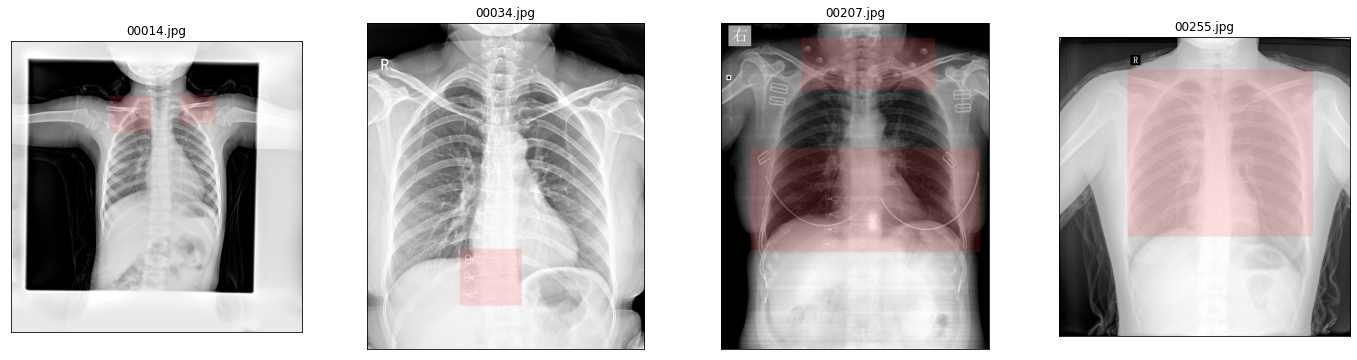

In [7]:
from google.colab import drive
drive.mount('/content/drive')

boxes = []
split = 'dev'

def annotation_to_bbox(annotation):
    bbox = []
    
    if not annotation:
        return bbox
    
    annotation_list = annotation.split(OBJECT_SEP)
    for anno in annotation_list:
        if anno[0] in ('0', '1'):
            box = rectangle_box(anno)
        elif anno[0] == '2':
            box = polylabel_box(anno)
        else:
            raise RuntimeError(anno[0])
        bbox.append(box)
    return bbox




def _get_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

OBJECT_SEP = ';'
ANNOTATION_SEP = ' '
def draw_annotation(im, anno_str, fill=(255, 63, 63, 40)):
    draw = ImageDraw.Draw(im, mode="RGBA")
    for anno in anno_str.split(OBJECT_SEP):
        anno = list(map(int, anno.split(ANNOTATION_SEP)))
        if anno[0] == 0:
            draw.rectangle(anno[1:], fill=fill)
        elif anno[0] == 1:
            draw.ellipse(anno[1:], fill=fill)
        else:
            draw.polygon(anno[1:], fill=fill)
            draw.polygon(anno[1:],fill = fill)
data_dir = 'drive/MyDrive/object-cxr/'
label_train = pd.read_csv(data_dir+'train.csv', na_filter = False)
label_dev = pd.read_csv(data_dir+'dev.csv', na_filter = False)

label_train = label_train.loc[label_train['annotation'].astype(bool)].reset_index(drop=True)
img_class_dict_tr = dict(zip(label_train.image_name, label_train.annotation))
img_class_dict_dev = dict(zip(label_dev.image_name, label_dev.annotation))
fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(xticks=[], yticks=[]),
                        figsize=(24, 6))

example_idxes = [127]
for row, ax in zip(label_train.iloc[example_idxes].itertuples(index=False), axs):
    im = Image.open(data_dir + "train/" + row.image_name).convert("RGB")
    if row.annotation:
        draw_annotation(im, row.annotation)
    
    ax.imshow(im)
    ax.set_title(f"{row.image_name}")



In [6]:
class ForeignObjectDataset(object):
    
    def __init__(self, datafolder, datatype='train', transform = True, labels_dict={}):
        self.datafolder = datafolder
        self.datatype = datatype
        self.labels_dict = labels_dict
        self.image_files_list = [s for s in sorted(os.listdir(datafolder)) if s in labels_dict.keys()]
        self.transform = transform
        self.annotations = [labels_dict[i] for i in self.image_files_list]
            
    def __getitem__(self, idx):
        # load images 
        img_name = self.image_files_list[idx]
        img_path = os.path.join(self.datafolder, img_name)
        img = Image.open(img_path).convert("RGB")
        width, height = img.size[0],img.size[1]  
        
        if self.datatype == 'train':
            annotation = self.labels_dict[img_name]
            
            boxes = []
            
            if type(annotation) == str:
                annotation_list = annotation.split(';')
                for anno in annotation_list:
                    x = []
                    y = []
                
                    anno = anno[2:]
                    anno = anno.split(' ')
                    for i in range(len(anno)):
                        if i % 2 == 0:
                            x.append(float(anno[i]))
                        else:
                            y.append(float(anno[i]))
                        
                    xmin = min(x)/width * 600
                    xmax = max(x)/width * 600
                    ymin = min(y)/height * 600
                    ymax = max(y)/height * 600
                    boxes.append([xmin, ymin, xmax, ymax])

            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((len(boxes),), dtype=torch.int64)

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            # suppose all instances are not crowd
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd
            
            if self.transform is not None:
                img = self.transform(img)
                
            return img, target
        
        if self.datatype == 'dev':
            
            if self.labels_dict[img_name] == '':
                label = 0
            else:
                label = 1
            
            if self.transform is not None:
                img = self.transform(img)

            return img, label, width, height

        

    def __len__(self):
        return len(self.image_files_list)



In [10]:
def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    data_transforms = transforms.Compose([
    transforms.Resize((600,600)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset_train = ForeignObjectDataset(datafolder= data_dir + 'train/',
                                         datatype='train', transform=data_transforms,
                                         labels_dict=img_class_dict_tr)
    dataset_dev = ForeignObjectDataset(datafolder= data_dir + 'dev/', datatype='dev',
                                       transform=data_transforms,
                                       labels_dict=img_class_dict_dev)



    # our dataset has two classes only - no object and have object

    num_classes = 2
    data_loader = torch.utils.data.DataLoader(
                  dataset_train, batch_size=8, shuffle= True, num_workers=4,
                  collate_fn=utils.collate_fn)
    data_loader_val = torch.utils.data.DataLoader(
        dataset_dev, batch_size=1, shuffle= False, num_workers=4,
        collate_fn=utils.collate_fn)
    
    model_ft = _get_detection_model(num_classes)
    model_ft.to(device)

    params = [p for p in model_ft.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=5,
                                                   gamma=0.1)

    num_epochs = 7

    auc_max = 0

    for epoch in range(num_epochs):
        
        train_one_epoch(model_ft, optimizer, data_loader, device, epoch, print_freq=20)
        
        lr_scheduler.step()
        
        model_ft.eval()
        val_pred = []
        val_label = []
        for batch_i, (image, label,  width, height) in enumerate(data_loader_val):
            image = list(img.to(device) for img in image)
            
            val_label.append(label[-1])

            outputs = model_ft(image)
            if len(outputs[-1]['boxes']) == 0:
                val_pred.append(0)
            else:
                val_pred.append(torch.max(outputs[-1]['scores']).tolist())
        
        val_pred_label = []
        for i in range(len(val_pred)):
            if val_pred[i] >= 0.5:
                val_pred_label.append(1)
            else:
                val_pred_label.append(0)
                
        number = 0
        
        for i in range(len(val_pred_label)):
            if val_pred_label[i] == val_label[i]:
                number += 1
        acc = number / len(val_pred_label)
        
        auc = roc_auc_score(val_label,val_pred)
        print('Epoch: ', epoch, '| val acc: %.4f' % acc, '| val auc: %.4f' % auc)
        
        if auc > auc_max:
            auc_max = auc
            print('Best Epoch: ', epoch, '| val acc: %.4f' % acc, '| Best val auc: %.4f' % auc_max)
            torch.save(model_ft.state_dict(), "model.pt")
            

In [11]:
main()

Epoch: [0]  [  0/500]  eta: 0:33:29  lr: 0.000015  loss: 1.4346 (1.4346)  loss_classifier: 0.9227 (0.9227)  loss_box_reg: 0.0105 (0.0105)  loss_objectness: 0.4814 (0.4814)  loss_rpn_box_reg: 0.0200 (0.0200)  time: 4.0190
Epoch: [0]  [ 20/500]  eta: 0:11:02  lr: 0.000215  loss: 0.5073 (0.6911)  loss_classifier: 0.1847 (0.3723)  loss_box_reg: 0.0485 (0.0585)  loss_objectness: 0.2115 (0.2430)  loss_rpn_box_reg: 0.0164 (0.0173)  time: 1.2473
Epoch: [0]  [ 40/500]  eta: 0:09:43  lr: 0.000415  loss: 0.2804 (0.5116)  loss_classifier: 0.1034 (0.2477)  loss_box_reg: 0.0620 (0.0609)  loss_objectness: 0.1158 (0.1874)  loss_rpn_box_reg: 0.0127 (0.0156)  time: 1.1514
Epoch: [0]  [ 60/500]  eta: 0:08:49  lr: 0.000616  loss: 0.2990 (0.4462)  loss_classifier: 0.1162 (0.2070)  loss_box_reg: 0.0799 (0.0689)  loss_objectness: 0.0850 (0.1559)  loss_rpn_box_reg: 0.0118 (0.0144)  time: 1.0733
Epoch: [0]  [ 80/500]  eta: 0:08:14  lr: 0.000816  loss: 0.3375 (0.4215)  loss_classifier: 0.1330 (0.1890)  loss_box

In [97]:
data_loader_val = torch.utils.data.DataLoader(
    dataset_dev, batch_size=1, shuffle= False, num_workers=4,
    collate_fn=utils.collate_fn)
model = _get_detection_model(2)
model.to(device)
model.load_state_dict(torch.load("model.pt"))

model.eval()
dataset_dev = ForeignObjectDataset(datafolder= data_dir + 'dev/', datatype='dev',
                                       transform=data_transforms,
                                       labels_dict=img_class_dict_dev)
data_transforms = transforms.Compose([
    transforms.Resize((600,600)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

preds = []
labels = []
locs = []
print(data_loader_val)
from tqdm import tqdm
for image, label, width, height in data_loader_val:
    
    image = list(img.to(device) for img in image)
    labels.append(label[-1])
    
    outputs = model(image)
    
    center_points = []
    center_points_preds = []
    
    if len(outputs[-1]['boxes']) == 0:
        preds.append(0)
        center_points.append([])
        center_points_preds.append('')
        locs.append('')
    else:
        preds.append(torch.max(outputs[-1]['scores']).tolist())
        
        new_output_index = torch.where((outputs[-1]['scores']>0.1))
        new_boxes = outputs[-1]['boxes'][new_output_index]
        new_scores = outputs[-1]['scores'][new_output_index]
        line = ''
        for i in range(len(new_boxes)):
            new_box = new_boxes[i].tolist()
            center_x = (new_box[0] + new_box[2])/2
            center_y = (new_box[1] + new_box[3])/2
            center_points.append([center_x/600 * width[-1],center_y/600 * height[-1]])
            if i == len(new_boxes)-1:
                line += str(center_points[i][0]) + ' ' + str(center_points[i][1]) + ' ' + str(new_box[0])+ ' ' + str(new_box[1])+ ' '+str(new_box[2])+' '+str(new_box[3])
            else:
                line += str(center_points[i][0]) + ' ' + str(center_points[i][1]) + ' ' + str(new_box[0])+ ' ' + str(new_box[1])+ ' '+str(new_box[2])+' '+str(new_box[3]) +';'
        locs.append(line)
        center_points_preds += new_scores.tolist()

        # for i in range(len(new_boxes)):
        #     new_box = new_boxes[i].tolist()
        #     # print(str(new_box[0]))
        #     if i == len(new_boxes)-1:
        #         line += str(center_points[i][0]) + ' ' + str(center_points[i][1]) + ' ' + str(new_box[0])+ ' ' + str(new_box[1])+ ' '+str(new_box[2])+' '+str(new_box[3])
        #     else:
        #         line += str(center_points[i][0]) + ' ' + str(center_points[i][1]) + ' ' + str(new_box[0])+ ' ' + str(new_box[1])+ ' '+str(new_box[2])+' '+str(new_box[3]) +';'
        # locs.append(line)

cls_res = pd.DataFrame({'image_name': dataset_dev.image_files_list, 'prediction': preds})
cls_res.to_csv('classification.csv', columns=['image_name', 'prediction'], sep=',', index=None)
print('classification.csv generated.')

loc_res = pd.DataFrame({'image_name': dataset_dev.image_files_list, 'prediction': locs})
loc_res.to_csv('localization.csv', columns=['image_name', 'prediction'], sep=',', index=None)
print('localization.csv generated.')




classification.csv generated.
localization.csv generated.


[314.3109130859375, 29.068565368652344, 364.3697509765625, 102.37748718261719]
[199.33627319335938, 88.70611572265625, 344.12506103515625, 148.86679077148438]
[184.05282592773438, 1.6326055526733398, 224.00074768066406, 67.9628677368164]
[438.48638916015625, 2.891143798828125, 474.51824951171875, 105.24268341064453]
[186.1839599609375, 67.16644287109375, 353.2414245605469, 172.35592651367188]
[369.89404296875, 105.37417602539062, 435.73931884765625, 210.36376953125]
[218.71273803710938, 108.40470886230469, 341.50244140625, 143.84353637695312]
[214.0646209716797, 34.97776794433594, 347.66094970703125, 146.12744140625]
[387.8192138671875, 84.53538513183594, 435.82928466796875, 183.07740783691406]
[224.37307739257812, 12.621039390563965, 299.109130859375, 94.98677062988281]
[424.349609375, 17.948890686035156, 582.4912109375, 165.84231567382812]
[433.19073486328125, 13.956284523010254, 582.2308349609375, 95.87545776367188]
[183.40081787109375, 26.034706115722656, 299.21807861328125, 114.76

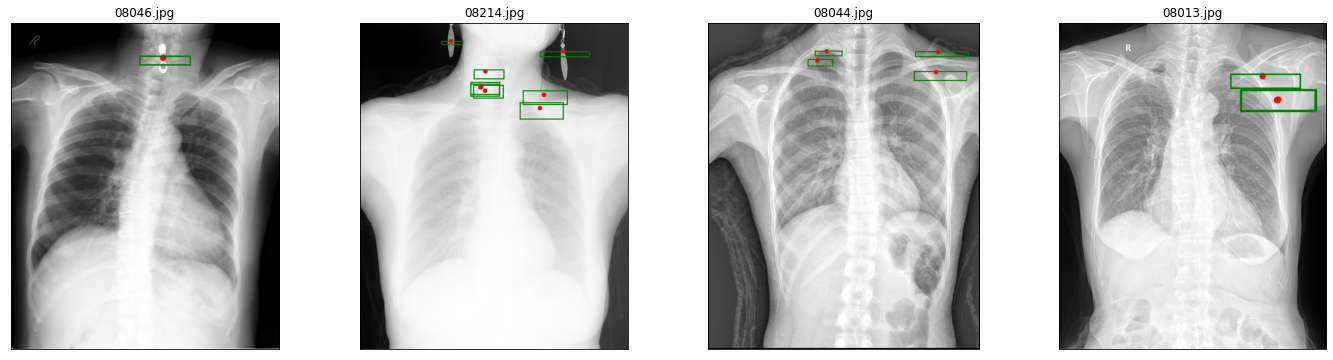

In [119]:
# viz

def draw_res(im,str,fill = (0, 0, 0, 40)):
  draw = ImageDraw.Draw(im, mode="RGBA")
  for centers in str.split(OBJECT_SEP):
    centers = list(map(float, centers.split(ANNOTATION_SEP)))
    print(centers[2:])
    cx,cy = centers[:2]
    x0,y0,x1,y1 = centers[2:]
    draw.ellipse((cx-20,cy-20,cx+20,cy+20), fill = '#ff0000')
    draw.rectangle((cx-x0/2,cy-y0/2,cx+x1/2,cy+y1/2), outline='green', width=10)

fig, axs = plt.subplots(
    nrows=1, ncols=4, subplot_kw=dict(xticks=[], yticks=[]), figsize=(24, 6)
)
label = pd.read_csv('localization.csv', na_filter=False)
example_idxes = [45,213,43,12]
for row, ax in zip(
    label.iloc[example_idxes].itertuples(index=False), axs
):
    im = Image.open(data_dir + "dev/" + row.image_name).convert("RGB")
    if row.prediction:
        draw_res(im,row.prediction)
    
    ax.imshow(im)
    ax.set_title(f"{row.image_name}")
